# Language Translation
In this project, you’re going to take a peek into the realm of neural network machine translation.  You’ll be training a sequence to sequence model on a dataset of English and French sentences that can translate new sentences from English to French.
## Get the Data
Since translating the whole language of English to French will take lots of time to train, we have provided you with a small portion of the English corpus.

https://cdn-images-1.medium.com/max/2000/1*8OZYn5yMAl4hfdfTwSwKyQ.png 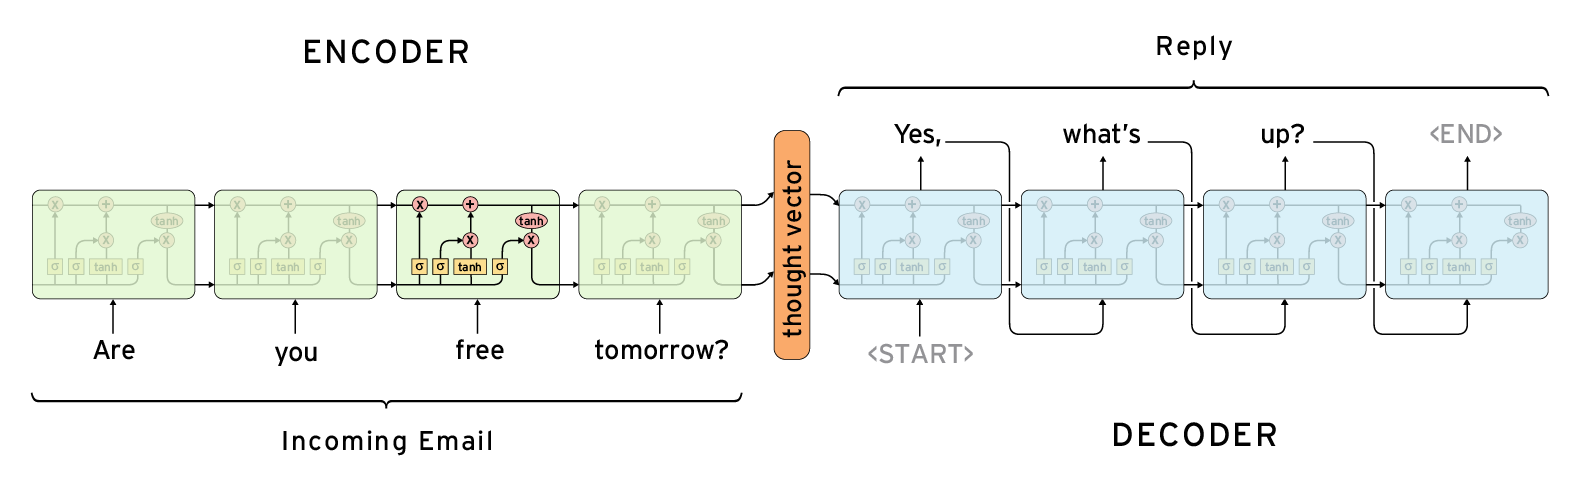

## Following are some helper functions

In [23]:
import os
import pickle
import copy
import numpy as np


CODES = {'<PAD>': 0, '<EOS>': 1, '<UNK>': 2, '<GO>': 3 }


def load_data(path):
    """
    Load Dataset from File
    """
    input_file = os.path.join(path)
    with open(input_file, 'r', encoding='utf-8') as f:
        data = f.read()

    return data


def preprocess_and_save_data(source_path, target_path, text_to_ids):
    """
    Preprocess Text Data.  Save to to file.
    """
    # Preprocess
    source_text = load_data(source_path)
    target_text = load_data(target_path)

    source_text = source_text.lower()
    target_text = target_text.lower()

    source_vocab_to_int, source_int_to_vocab = create_lookup_tables(source_text)
    target_vocab_to_int, target_int_to_vocab = create_lookup_tables(target_text)

    source_text, target_text = text_to_ids(source_text, target_text, source_vocab_to_int, target_vocab_to_int)

    # Save Data
    pickle.dump((
        (source_text, target_text),
        (source_vocab_to_int, target_vocab_to_int),
        (source_int_to_vocab, target_int_to_vocab)), open('preprocess.p', 'wb'))


def load_preprocess():
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    return pickle.load(open('preprocess.p', mode='rb'))


def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary
    """
    vocab = set(text.split())
    vocab_to_int = copy.copy(CODES)

    for v_i, v in enumerate(vocab, len(CODES)):
        vocab_to_int[v] = v_i

    int_to_vocab = {v_i: v for v, v_i in vocab_to_int.items()}

    return vocab_to_int, int_to_vocab


def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))


def batch_data(source, target, batch_size):
    """
    Batch source and target together
    """
    for batch_i in range(0, len(source)//batch_size):
        start_i = batch_i * batch_size
        source_batch = source[start_i:start_i + batch_size]
        target_batch = target[start_i:start_i + batch_size]
        yield np.array(pad_sentence_batch(source_batch)), np.array(pad_sentence_batch(target_batch))


def pad_sentence_batch(sentence_batch):
    """
    Pad sentence with <PAD> id
    """
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    print(max_sentence)
    return [sentence + [CODES['<PAD>']] * (max_sentence - len(sentence))
            for sentence in sentence_batch]


In [24]:
# Load data

source_path = 'data/small_vocab_en'
target_path = 'data/small_vocab_fr'
source_text = load_data(source_path)
target_text = load_data(target_path)

## Explore the Data
Play around with view_sentence_range to view different parts of the data.

In [17]:
view_sentence_range = (0, 10)

import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in source_text.split()})))


sentences = source_text.split('\n')
word_counts = [len(sentence.split()) for sentence in sentences]
print('Number of sentences: {}'.format(len(sentences)))
print('Average number of words in a sentence: {}'.format(np.average(word_counts)))

print()
print('English sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(source_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))
print()
print('French sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(target_text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

Dataset Stats
Roughly the number of unique words: 227
1
Number of sentences: 137861
Average number of words in a sentence: 13.225277634719028

English sentences 0 to 10:
new jersey is sometimes quiet during autumn , and it is snowy in april .
the united states is usually chilly during july , and it is usually freezing in november .
california is usually quiet during march , and it is usually hot in june .
the united states is sometimes mild during june , and it is cold in september .
your least liked fruit is the grape , but my least liked is the apple .
his favorite fruit is the orange , but my favorite is the grape .
paris is relaxing during december , but it is usually chilly in july .
new jersey is busy during spring , and it is never hot in march .
our least liked fruit is the lemon , but my least liked is the grape .
the united states is sometimes busy during january , and it is sometimes warm in november .

French sentences 0 to 10:
new jersey est parfois calme pendant l' automn

# Solution 

## Implement Preprocessing Function
### Text to Word Ids
As you did with other RNNs, you must turn the text into a number so the computer can understand it. In the function `text_to_ids()`, you'll turn `source_text` and `target_text` from words to ids.  However, you need to add the `<EOS>` word id at the end of each sentence from `target_text`.  This will help the neural network predict when the sentence should end.

You can get the `<EOS>` word id by doing:
```python
target_vocab_to_int['<EOS>']
```
You can get other word ids using `source_vocab_to_int` and `target_vocab_to_int`.

### Preprocess all the data and save it
Running the code cell below will preprocess all the data and save it to file.

## Build the Neural Network
You'll build the components necessary to build a Sequence-to-Sequence model by implementing the following functions below:
- `model_inputs`
- `process_decoding_input`
- `encoding_layer`
- `decoding_layer_train`
- `decoding_layer_infer`
- `decoding_layer`
- `seq2seq_model`

### Input
Implement the `model_inputs()` function to create TF Placeholders for the Neural Network. It should create the following placeholders:

- Input text placeholder named "input" using the TF Placeholder name parameter with rank 2.
- Targets placeholder with rank 2.
- Learning rate placeholder with rank 0.
- Keep probability placeholder named "keep_prob" using the TF Placeholder name parameter with rank 0.

Return the placeholders in the following the tuple (Input, Targets, Learing Rate, Keep Probability)

### Process Decoding Input
Implement `process_decoding_input` using TensorFlow to remove the last word id from each batch in `target_data` and concat the GO ID to the begining of each batch.

### Encoding
Implement `encoding_layer()` to create a Encoder RNN layer using [`tf.nn.dynamic_rnn()`](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn).

### Decoding - Training
Create training logits using [`tf.contrib.seq2seq.simple_decoder_fn_train()`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/simple_decoder_fn_train) and [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder).  Apply the `output_fn` to the [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder) outputs.

### Decoding - Inference
Create inference logits using [`tf.contrib.seq2seq.simple_decoder_fn_inference()`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/simple_decoder_fn_inference) and [`tf.contrib.seq2seq.dynamic_rnn_decoder()`](https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/dynamic_rnn_decoder). 

### Build the Decoding Layer
Implement `decoding_layer()` to create a Decoder RNN layer.

- Create RNN cell for decoding using `rnn_size` and `num_layers`.
- Create the output fuction using [`lambda`](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) to transform it's input, logits, to class logits.
- Use the your `decoding_layer_train(encoder_state, dec_cell, dec_embed_input, sequence_length, decoding_scope, output_fn, keep_prob)` function to get the training logits.
- Use your `decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id, end_of_sequence_id, maximum_length, vocab_size, decoding_scope, output_fn, keep_prob)` function to get the inference logits.

Note: You'll need to use [tf.variable_scope](https://www.tensorflow.org/api_docs/python/tf/variable_scope) to share variables between training and inference.

### Build the Neural Network
Apply the functions you implemented above to:

- Apply embedding to the input data for the encoder.
- Encode the input using your `encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob)`.
- Process target data using your `process_decoding_input(target_data, target_vocab_to_int, batch_size)` function.
- Apply embedding to the target data for the decoder.
- Decode the encoded input using your `decoding_layer(dec_embed_input, dec_embeddings, encoder_state, vocab_size, sequence_length, rnn_size, num_layers, target_vocab_to_int, keep_prob)`.

## Neural Network Training
### Hyperparameters
Tune the following parameters:

- Set `epochs` to the number of epochs.
- Set `batch_size` to the batch size.
- Set `rnn_size` to the size of the RNNs.
- Set `num_layers` to the number of layers.
- Set `encoding_embedding_size` to the size of the embedding for the encoder.
- Set `decoding_embedding_size` to the size of the embedding for the decoder.
- Set `learning_rate` to the learning rate.
- Set `keep_probability` to the Dropout keep probability

### Build the Graph
Build the graph using the neural network you implemented.

### Train
Train the neural network on the preprocessed data. If you have a hard time getting a good loss, check the forms to see if anyone is having the same problem.

### Save Parameters
Save the `batch_size` and `save_path` parameters for inference.

## Sentence to Sequence
To feed a sentence into the model for translation, you first need to preprocess it.  Implement the function `sentence_to_seq()` to preprocess new sentences.

- Convert the sentence to lowercase
- Convert words into ids using `vocab_to_int`
 - Convert words not in the vocabulary, to the `<UNK>` word id.

## Translate
This will translate `translate_sentence` from English to French.

# Ref

https://github.com/RomelTorres/DLND-language-translation

https://medium.com/@umerfarooq_26378/neural-machine-translation-with-code-68c425044bbd

https://medium.com/@ageitgey/machine-learning-is-fun-part-5-language-translation-with-deep-learning-and-the-magic-of-sequences-2ace0acca0aa